In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from copy import deepcopy
from sklearn.metrics import silhouette_score
import pandas as pd 
import torch.optim as optim
from braingeneers.analysis import SpikeData
import os
import json
import pytorch_lightning as pl
from backbones import ResNet18Enc, ResNet18Dec
import wandb
import pickle
from tqdm import tqdm
import scanpy as sc 
import matplotlib.pyplot as plt 
from torch.optim.lr_scheduler import ReduceLROnPlateau
import anndata as an 
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping

In [2]:
waveform_files = ["data/" + f for f in os.listdir("./data") if f.endswith('.npy')]
meta_files = [f.replace('.npy', '.json') for f in waveform_files]

waveforms = []
isi_dist = []

for wf, mf in zip(waveform_files, meta_files):
    with open(mf, 'r') as file:
        json_data = json.load(file)

    sd = SpikeData([json_data[key]['train'] for key in json_data.keys()])
    trains = sd.train

    all_isi = sd.interspike_intervals()
    
    bad_indices = []
    for idx, isi in enumerate(all_isi):
        hist, _ = np.histogram(isi[isi < 0.1], bins=64, density=True)
        if not np.isnan(hist).all():
            isi_dist.append(hist)
        else:
            bad_indices.append(idx)
    
    waveform_data = np.load(wf)
    if bad_indices:
        waveform_data = np.delete(waveform_data, np.array(bad_indices), axis=0)

    waveforms.append(waveform_data)



/Users/julian/miniconda3/envs/braingeneers/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


In [3]:
waveforms = np.concatenate(waveforms, axis=0)
isi_dist = np.stack(isi_dist)

In [6]:
class EphysDataset(Dataset):
    def __init__(self, waveforms, isi_dists, normalize=True):
        self.waveforms = np.array(waveforms)
        self.isi_dists = np.array(isi_dists)
        
        assert len(self.waveforms) == len(self.isi_dists)
        self.normalize = normalize
        
    def __getitem__(self, idx):
        waveform = torch.as_tensor(self.waveforms[idx, ...]).float()
        
        isi_dist = torch.as_tensor(self.isi_dists[idx, ...]).float()
        isi_dist = torch.log(isi_dist + 1)

        if self.normalize:
            waveform = (waveform - waveform.mean()) / waveform.std()
            isi_dist = (isi_dist - isi_dist.mean()) / isi_dist.std()

        waveform = waveform.view(1, 1, -1)
        waveform = F.interpolate(waveform, size=(64,), mode='linear').view(1, -1)
        
        isi_dist = isi_dist.view(1, 1, -1)
        isi_dist = F.interpolate(isi_dist, size=(64,), mode='linear').view(1, -1)

        return waveform, isi_dist
    
    def __len__(self):
        return len(self.waveforms)

In [7]:
# class ContrastiveLoss(nn.Module):
#     def __init__(self, batch_size, temperature=0.5):
#         super().__init__()
#         self.batch_size = batch_size
#         self.register_buffer("temperature", torch.tensor(temperature))
#         self.register_buffer("negatives_mask", (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float())
            
#     def forward(self, emb_i, emb_j):
#         """
#         emb_i and emb_j are batches of embeddings, where corresponding indices are pairs
#         z_i, z_j as per SimCLR paper
#         """
#         z_i = F.normalize(emb_i, dim=1)
#         z_j = F.normalize(emb_j, dim=1)

#         representations = torch.cat([z_i, z_j], dim=0)
#         similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)
        
#         sim_ij = torch.diag(similarity_matrix, self.batch_size)
#         sim_ji = torch.diag(similarity_matrix, -self.batch_size)
#         positives = torch.cat([sim_ij, sim_ji], dim=0)

#         nominator = torch.exp(positives / self.temperature)
#         denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)

#         loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
#         loss = torch.sum(loss_partial) / (2 * self.batch_size)
#         return loss

def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

class CLIPLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.register_buffer("temperature", torch.tensor(temperature))
            
    def forward(self, emb_i, emb_j):
        logits = (emb_i @ emb_j.T) / self.temperature
        emb_i_similarity = emb_i @ emb_i.T
        emb_j_similarity = emb_j @ emb_j.T

        targets = F.softmax(
            (emb_i_similarity + emb_j_similarity) / 2 * self.temperature, dim=-1
        )

        emb_i_loss = cross_entropy(logits, targets, reduction='none')
        emb_j_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (emb_i_loss + emb_j_loss) / 2.0 # shape: (batch_size)
        return loss.mean()
        

In [8]:
class UnimodalModel(nn.Module):
    def __init__(self, z_dim, projector=True):
        super().__init__()
        
        self.encoder = nn.Sequential(
            ResNet18Enc(z_dim=z_dim),
            nn.Linear(z_dim*2, z_dim),
        )
        
        self.decoder = nn.Sequential(
            nn.BatchNorm1d(z_dim),
            nn.Linear(z_dim, z_dim*2),
            nn.BatchNorm1d(z_dim*2),
            ResNet18Dec(z_dim=z_dim)
        )
        
    def forward(self, x):
        enc_x = self.encoder(x)
        dec_x = self.decoder(enc_x)
        
        return enc_x, dec_x

class UnimodalEmbeddingModel(pl.LightningModule):
    def __init__(self, mode, base_model):
        super().__init__()
        assert mode in ("wave", "time")
        self.mode = mode
        self.model = base_model

        self.mse_loss = nn.MSELoss()
        self.val_loss = []
        self.train_loss = []

    def training_step(self, batch, batch_idx):
        if self.mode == "wave":
            data = batch[0]
        else:
            data = batch[1]
        
        enc, dec = self.model(data)
        loss = self.mse_loss(dec, data)
        
        norms = grad_norm(self.model.encoder, norm_type=2)
        self.log_dict(norms)
        norms = grad_norm(self.model.decoder, norm_type=2)
        self.log_dict(norms)

        self.train_loss.append(loss.item())
        self.log('train_loss', loss)
        
        return loss

    def validation_step(self, batch, batch_idx):
        if self.mode == "wave":
            data = batch[0]
        else:
            data = batch[1]
        
        enc, dec = self.model(data)
        loss = self.mse_loss(dec, data)
        
        self.val_loss.append(loss.item())
        self.log('val_loss', loss)
        
        return loss
    
    def on_validation_epoch_end(self):
        avg_loss = sum(self.val_loss) / len(self.val_loss)
        print(f"Average validation loss is {avg_loss:.2f}")
        self.val_loss = []
        
    def on_train_epoch_end(self):
        avg_loss = sum(self.train_loss) / len(self.train_loss)
        print(f"Average training loss is {avg_loss:.2f}")
        self.train_loss = []

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=0.01)
        lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.8)

        return {
            "lr_scheduler": {
                "scheduler": lr_scheduler,
                "monitor": "val_loss",
            },
            "optimizer": optimizer,
        }
    
    def forward(self, x):
        return self.model(x)

In [9]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim,
        dropout=0.5,
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

class MixedModel(nn.Module):
    def __init__(self, z_dim, projector=True):
        super().__init__()
        
        self.wave_encoder = ResNet18Enc(z_dim=z_dim)
        # self.wave_projector = self.make_projection(z_dim) if projector else nn.Identity()
            
        self.time_encoder = ResNet18Enc(z_dim=z_dim)
        # self.time_projector = self.make_projection(z_dim) if projector else nn.Identity()
        
        self.wave_decoder = nn.Sequential(ResNet18Dec(z_dim=z_dim))
        self.time_decoder = nn.Sequential(ResNet18Dec(z_dim=z_dim))
        
    def forward(self, wave, time):
        e_wave = self.wave_encoder(wave)
        e_time = self.time_encoder(time)

        # e_wave = self.wave_projector(e_wave)
        # e_time = self.time_projector(e_time)

        d_wave, d_time = self.wave_decoder(e_wave), self.time_decoder(e_time)

        return e_wave, e_time, d_wave, d_time

    def make_projection(self, z_dim):
        return ProjectionHead(
            embedding_dim=z_dim,
            projection_dim=z_dim,
        )

In [10]:
model = MixedModel(
    z_dim=2,
)

w, t = torch.randn(8, 1, 64), torch.randn(8, 1, 64)

x,y,z,w = model(w, t)
x.shape, y.shape, z.shape, w.shape

(torch.Size([8, 4]),
 torch.Size([8, 4]),
 torch.Size([8, 1, 64]),
 torch.Size([8, 1, 64]))

In [11]:
from pytorch_lightning.utilities import grad_norm

class MultimodalEmbeddingModel(pl.LightningModule):
    def __init__(self, base_model, batch_size, contrastive_loss_weight=1.0, temperature=0.5, lr=0.01):
        super().__init__()
        self.model = base_model
        self.contrastive_loss_weight = contrastive_loss_weight
        self.mse_loss = nn.MSELoss()
        self.contrastive_loss = CLIPLoss(temperature=temperature)
        self.lr = lr

    def training_step(self, batch, batch_idx):
        wave, time = batch
        rep_w, rep_t, decode_w, decode_t = self.model(wave, time)

        mse_loss_w = self.mse_loss(decode_w, wave)
        mse_loss_t = self.mse_loss(decode_t, time)
        mse_loss = waveform_importance * mse_loss_w + (1-waveform_importance) * mse_loss_t

        emb_i, emb_j = rep_w, rep_t
        #contrastive_loss = self.contrastive_loss(emb_i, emb_j)

        # Combine losses
        total_loss = mse_loss #+ self.contrastive_loss_weight# * contrastive_loss

        self.log('train_loss', total_loss)
        self.log('train_mse_loss', mse_loss)
        #self.log('train_xe_loss', contrastive_loss)
        
        norms = grad_norm(self.model.wave_encoder, norm_type=2)
        self.log_dict(norms)
        norms = grad_norm(self.model.wave_decoder, norm_type=2)
        self.log_dict(norms)

        return total_loss

    def validation_step(self, batch, batch_idx):
        wave, time = batch
        rep_w, rep_t, decode_w, decode_t = self.model(wave, time)

        mse_loss_w = self.mse_loss(decode_w, wave)
        mse_loss_t = self.mse_loss(decode_t, time)
        mse_loss = mse_loss_w + mse_loss_t

        emb_i, emb_j = rep_w, rep_t
        contrastive_loss = self.contrastive_loss(emb_i, emb_j)

        # Combine losses
        total_loss = mse_loss + self.contrastive_loss_weight * contrastive_loss

        self.log('val_loss', total_loss)
        self.log('val_mse_loss', mse_loss)
        #self.log('val_xe_loss', contrastive_loss)

        return total_loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.lr)
        lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08, verbose=False)
        
        return {'optimizer': optimizer, 'lr_scheduler': lr_scheduler, "monitor": "val_loss"}

In [23]:
# base_model = UnimodalModel(z_dim=5)
# base_model(torch.randn(8, 1, 64))

In [139]:
def train_unimodal_model(mode):
    wandb.init(reinit=True)
    bs = 64
    wf_train, isi_train = waveforms[:15000], isi_dist[:15000]
    wf_val, isi_val = waveforms[15000:], isi_dist[15000:]

    traindata = EphysDataset(wf_train, isi_train)
    valdata = EphysDataset(wf_val, isi_val)

    train_loader = DataLoader(traindata, batch_size=bs, drop_last=True)
    val_loader = DataLoader(valdata, batch_size=bs, drop_last=True)

    base_model = UnimodalModel(z_dim=5)

    model = UnimodalEmbeddingModel(mode=mode, base_model=base_model)
    ckpt_callback = pl.callbacks.ModelCheckpoint(dirpath=f"./{mode}_model", monitor="val_loss")

    trainer = pl.Trainer(
        logger=pl.loggers.WandbLogger(),
        callbacks=[ckpt_callback],
        log_every_n_steps=5,
        max_epochs=15,
    )

    trainer.fit(model, train_loader, val_loader)
    
    return base_model

In [140]:
# wave_model = train_unimodal_model("wave")

# with open('wave_model.pkl', 'wb') as f:
#     pickle.dump(wave_model, f)

In [141]:
# time_model = train_unimodal_model("time")

# with open('isi_model.pkl', 'wb') as f:
#     pickle.dump(time_model, f)

In [24]:
base_model = MixedModel(z_dim=5)

with open('wave_model.pkl', 'rb') as f:
    wave_model = pickle.load(f)

with open('isi_model.pkl', 'rb') as f:
    time_model = pickle.load(f)

# copy over encoder
base_model.wave_encoder = wave_model.encoder
base_model.time_encoder = time_model.encoder

# copy over decoder
base_model.wave_decoder = wave_model.decoder
base_model.time_decoder = time_model.decoder

In [25]:
wandb.init(reinit=True)

bs = 1024
wf_train, isi_train = waveforms[:20000], isi_dist[:20000]
wf_val, isi_val = waveforms[20000:], isi_dist[20000:]

traindata = EphysDataset(wf_train, isi_train)
valdata = EphysDataset(wf_val, isi_val)

train_loader = DataLoader(traindata, batch_size=bs, drop_last=True, shuffle=True)
val_loader = DataLoader(valdata, batch_size=bs, drop_last=True)

In [27]:
base_model

MixedModel(
  (wave_encoder): Sequential(
    (0): ResNet18Enc(
      (conv1): Conv1d(1, 64, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (layer1): Sequential(
        (0): BasicBlockEnc(
          (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (shortcut): Sequential()
        )
        (1): BasicBlockEnc(
          (conv1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,),

In [28]:
wandb.init(reinit=True)
model = MultimodalEmbeddingModel.load_from_checkpoint(
    './lightning_logs/6cvz1lvj/checkpoints/epoch=27-step=532.ckpt',
    base_model=base_model,
    batch_size=bs,
    temperature=0.5,
    lr=0.001,
)

# trainer = pl.Trainer(
#     logger=pl.loggers.WandbLogger(),
#     log_every_n_steps=1,
#     max_epochs=-1,
#     callbacks=[
#         ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min'),
#     ]
# )

# trainer.fit(model, train_loader, val_loader)

In [68]:
# Load data from CSV files
waveforms_labeled = pd.read_csv("data/Waveforms.csv", index_col="Unnamed: 0")
isi_dist_labeled = pd.read_csv("data/isitransposed.csv", index_col="Unnamed: 0")
labels = pd.read_csv("data/CellType.csv", index_col="Unnamed: 0")

# Create the dataset
labeled_data = EphysDataset(waveforms_labeled, isi_dist_labeled)

# Split the dataset and get the indices
dataset_size = len(labeled_data)
indices = list(range(dataset_size))
train_size = int(0.5 * dataset_size)
test_size = dataset_size - train_size
train_indices, test_indices = random_split(indices, [train_size, test_size])

# Create Subset datasets
train_dataset = torch.utils.data.Subset(labeled_data, train_indices)
test_dataset = torch.utils.data.Subset(labeled_data, test_indices)

train_dataset = DataLoader(train_dataset, batch_size=64)
test_dataset = DataLoader(test_dataset, batch_size=64)

In [47]:
dir(train_indices)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getitems__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_is_protocol',
 'dataset',
 'indices']

In [66]:
wandb.init(reinit=True)

model = MultimodalEmbeddingModel.load_from_checkpoint(
    './lightning_logs/6cvz1lvj/checkpoints/epoch=27-step=532.ckpt',
    base_model=base_model,
    batch_size=bs,
    temperature=0.5,
    lr=0.001
)

trainer = pl.Trainer(
    logger=pl.loggers.WandbLogger(),
    log_every_n_steps=1,
    max_epochs=-1,
    callbacks=[
        ModelCheckpoint(monitor='val_loss', save_top_k=1, mode='min'),
    ]
)

trainer.fit(model, train_dataset, test_dataset)

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
grad_2.0_norm/0.bias,█▂▂▃▂▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_2.0_norm/0.bn1.bias,█▂▃▂▃▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_2.0_norm/0.bn1.weight,█▃▃▂▃▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_2.0_norm/0.conv1.weight,█▃▃▃▃▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_2.0_norm/0.layer1.0.bn1.bias,█▃▃▂▃▁▂▃▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_2.0_norm/0.layer1.0.bn1.weight,█▃▃▂▃▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_2.0_norm/0.layer1.0.bn2.bias,█▃▃▃▂▁▂▃▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_2.0_norm/0.layer1.0.bn2.weight,█▃▃▂▃▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_2.0_norm/0.layer1.0.conv1.weight,█▃▃▂▃▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
grad_2.0_norm/0.layer1.0.conv2.weight,█▃▂▃▃▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/julian/miniconda3/envs/braingeneers/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:391: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
/Users/julian/miniconda3/envs/braingeneers/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name             | Type       | Params
------------------------------------------------
0 | model            | MixedModel | 16.1 M
1 | mse_loss         | MSELoss    | 0     
2 | contrastive_loss | CLIPLoss   | 0     
-----------------------------------------

Sanity Checking: |                                                                                            …

/Users/julian/miniconda3/envs/braingeneers/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/julian/miniconda3/envs/braingeneers/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

/Users/julian/miniconda3/envs/braingeneers/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [52]:
class LinearProbe(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.l1 = nn.LazyLinear(num_classes)
        
    def forward(self, x):
        return self.l1(x)

linearprobe = LinearProbe(labels["V1"].nunique())

In [69]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
test_labels = torch.as_tensor(le.fit_transform(labels.iloc[test_indices.indices]["V1"]))
optimizer = torch.optim.AdamW(linearprobe.parameters(), lr=0.01)

In [ ]:
for param in model.parameters():
    param.requires_grad = False
    
for _ in range(5):
    for wave, time in test_data:
        rep_w, rep_t, decode_w, decode_t = model.model(wave, time)
        
        out_w, out_t = linearprobe(rep_w), linearprobe(rep_t)
        loss = F.cross_entropy_loss()

In [72]:
model.eval()

wf_embed = []
isi_embed = []

with torch.no_grad():
    for sample in test_dataset:
        rep_w, rep_t, decode_w, decode_t = model.model(*sample)
        rep_w, rep_t = F.normalize(rep_w, -1), F.normalize(rep_t, -1)

        wf_embed.append(rep_w)
        isi_embed.append(rep_t)

enc_wave_adata = an.AnnData(torch.cat(wf_embed, dim=0).numpy())
enc_isi_adata = an.AnnData(torch.cat(isi_embed, dim=0).numpy())

enc_wave_adata.obs["label"] = labels.iloc[test_indices.indices]["V1"].values
enc_isi_adata.obs["label"] = labels.iloc[test_indices.indices]["V1"].values

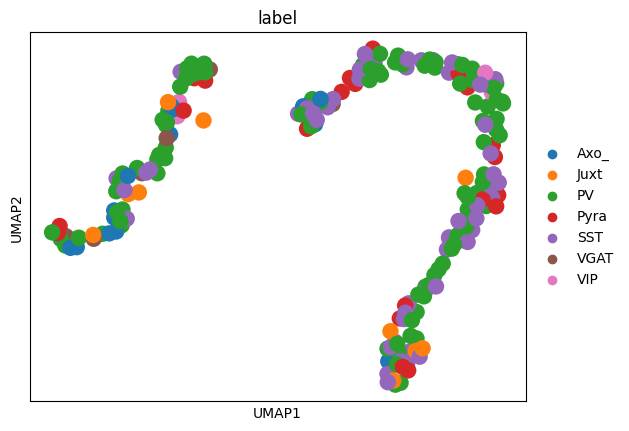

In [73]:
sc.pp.neighbors(enc_wave_adata, n_pcs=None)
sc.tl.leiden(enc_wave_adata)
sc.tl.umap(enc_wave_adata, min_dist=0.5)
sc.pl.umap(enc_wave_adata, color='label')

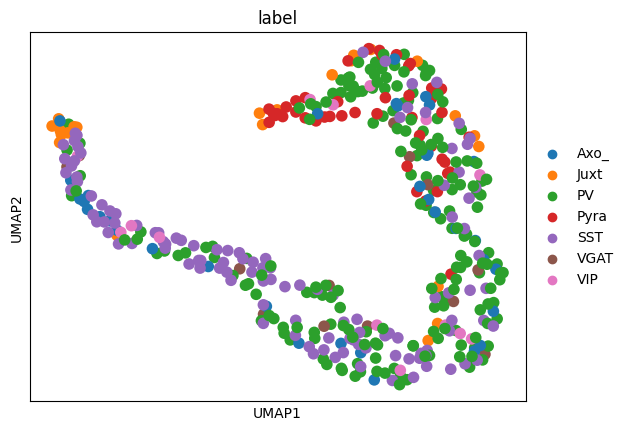

In [222]:
sc.pp.neighbors(enc_isi_adata, n_pcs=None)
sc.tl.leiden(enc_isi_adata)
sc.tl.umap(enc_isi_adata, min_dist=0.9)
sc.pl.umap(enc_isi_adata, color='label')

/Users/julian/miniconda3/envs/braingeneers/lib/python3.10/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


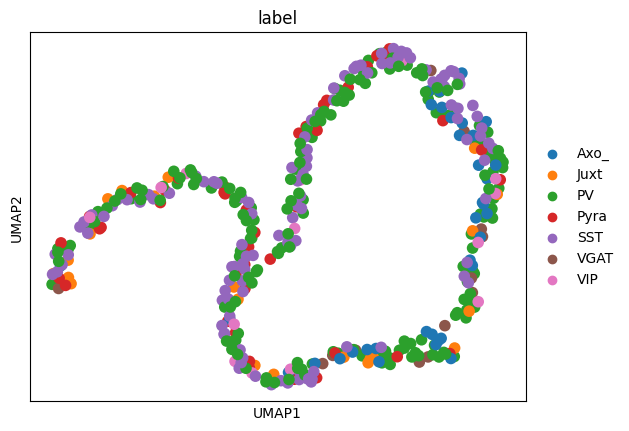

In [201]:
concat = an.concat([enc_isi_adata, enc_wave_adata], axis=1)
concat.obs["label"] = labels["V1"].values

sc.pp.neighbors(concat, n_pcs=None)
sc.tl.leiden(concat)
sc.tl.umap(concat, min_dist=0.9)
sc.pl.umap(concat, color='label')

""
0
1
2
3
4
...
425
426
427
428


# Calculate accuracy on val set using cosine distance

In [ ]:
import torch
from tqdm import tqdm

def calculate_top_k_accuracy(model, val_loader, k=5):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for sample in tqdm(val_loader):
            enc_x1, enc_y1, _, _ = model.model(*sample)

            # Compute cosine similarity between enc_x1 and enc_y1
            similarity_scores = torch.mm(enc_x1, enc_y1.T)

            # Get the top-k similarity scores and indices
            _, top_k_indices = torch.topk(similarity_scores, k, dim=1)

            # Check if the correct index is in the top-k indices
            correct_indices = (top_k_indices == torch.arange(len(top_k_indices))[:, None]).any(dim=1)
            correct += correct_indices.sum().item()
            total += len(correct_indices)

    top_k_accuracy = correct / total
    return top_k_accuracy

# Usage
top_5_accuracy = calculate_top_k_accuracy(model, val_loader, k=5)
print(f"Top-5 Accuracy: {top_5_accuracy:.4f}")

In [ ]:
top_5_accuracy = calculate_top_k_accuracy(model, val_loader, k=100)
print(f"Top-5 Accuracy: {top_5_accuracy:.4f}")

In [ ]:
import matplotlib.pyplot as plt

def plot_waveforms_grid(data):
    N, C = data.shape
    ncols = 4
    nrows = -(-N // ncols)  # Ceiling division to calculate number of rows
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 3 * nrows))
    axs = axs.flatten()

    for i in range(N):
        axs[i].plot(data[i])

    plt.tight_layout()
    plt.show()

sample = next(iter(val_loader))

ew, ei, di, dt = model.model(*sample)
plot_waveforms_grid(di.squeeze().detach()[0:8, ...])

plot_waveforms_grid(sample[0].squeeze()[0:8, ...])

model.model.eval()
ew, ei, di, dt = model.model(*sample)
plot_waveforms_grid(dt.squeeze().detach()[0:8, ...])

plot_waveforms_grid(sample[1].squeeze()[0:8, ...])